In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [2]:
data = pd.read_csv('train.csv')
data.head()
data.tail()

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,31962,0,thank you @user for you follow


In [3]:
data['pre_clean_len'] = [len(t) for t in data.tweet]
data.head(10)

,id,label,tweet,pre_clean_len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,118
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before the...,116
6,7,0,@user camping tomorrow @user @user @user @use...,77
7,8,0,the next school year is the year for exams.ð...,151
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,90
9,10,0,@user @user welcome here ! i'm it's so #gr...,50


In [4]:
from pprint import pprint
data_dict = {
    'label':{
        'type':data.label.dtype,
        'description':'label class - 0:negative, 1:positive'
    },
    'tweet':{
        'type':data.tweet.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':data.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':data.shape
}
pprint(data_dict)

{'dataset_shape': (31962, 4),
 'label': {'description': 'label class - 0:negative, 1:positive',
           'type': dtype('int64')},
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'tweet': {'description': 'tweet text', 'type': dtype('O')}}


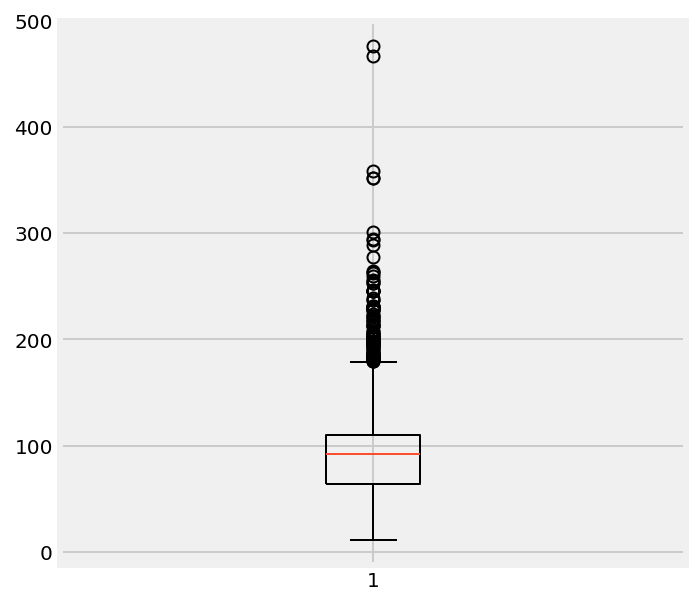

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.pre_clean_len)
plt.show()

In [6]:
data[data.pre_clean_len > 140].head(10)

,id,label,tweet,pre_clean_len
7,8,0,the next school year is the year for exams.ð...,151
26,27,0,@user all #smiles when #media is !! ðð...,149
107,108,0,just received dis from @user can't wait to sta...,146
136,137,0,ððððâ¨â­ï¸ #ãããã bih...,151
138,139,0,happy bihday chris evansðððððð...,206
149,150,0,be n #healthy freedom from effo in the prese...,141
214,215,0,ðððâ¤ï¸ egãï¼ï¼ï¼ smile!!!!!â...,141
246,247,0,@user @user @user thank you very much for this...,148
335,336,0,watching the @user leadership embrace &amp; ki...,146
378,379,0,@user my sister ain't even know i was watchin...,142


In [7]:
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [8]:
nums = [0,31961,800000,1200000,1600000]
print ("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(data['tweet'][i]))

Cleaning and parsing the tweets...



/home/kunal/anaconda3/lib/python2.7/encodings/utf_8_sig.py:19: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if input[:3] == codecs.BOM_UTF8:


Tweets 10000 of 31961 has been processed
Tweets 20000 of 31961 has been processed
Tweets 30000 of 31961 has been processed


In [9]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['tweet'])
clean_df['id'] = data.id
clean_df['label'] = data.label
clean_df.head()

,tweet,id,label
0,when father is dysfunctional and is so selfish...,1,0
1,thanks for lyft credit can not use cause they ...,2,0
2,bihday your majesty,3,0
3,model love take with all the time in ur,4,0
4,factsguide society now motivation,5,0


In [10]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,tweet,id,label
0,when father is dysfunctional and is so selfish...,1,0
1,thanks for lyft credit can not use cause they ...,2,0
2,bihday your majesty,3,0
3,model love take with all the time in ur,4,0
4,factsguide society now motivation,5,0


In [11]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31961 entries, 0 to 31960
Data columns (total 3 columns):
tweet    31958 non-null object
id       31961 non-null int64
label    31961 non-null int64
dtypes: int64(2), object(1)
memory usage: 998.8+ KB


In [12]:
my_df[my_df.isnull().any(axis=1)].head()

,tweet,id,label
4799,NaN,4800,0
5235,NaN,5236,0
30270,NaN,30271,0


In [13]:
np.sum(my_df.isnull().any(axis=1))

3

In [14]:
my_df.isnull().any(axis=0)

tweet     True
id       False
label    False
dtype: bool

In [15]:
df = pd.read_csv("train.csv")
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

,id,label,tweet
4799,4800,0,@user @user @user @user @user @user @user @us...
5235,5236,0,@user @user @user @user @user @user @user @us...
30270,30271,0,o m a y g a d


In [16]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31958 entries, 0 to 31957
Data columns (total 3 columns):
tweet    31958 non-null object
id       31958 non-null int64
label    31958 non-null int64
dtypes: int64(2), object(1)
memory usage: 749.1+ KB


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.tweet)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
len(cvec.get_feature_names())

37524

In [19]:
neg_doc_matrix = cvec.transform(my_df[my_df.label == 0].tweet)
pos_doc_matrix = cvec.transform(my_df[my_df.label == 1].tweet)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()


In [20]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:100]

,negative,positive,total
the,9396,843,10239
to,9300,568,9868
you,5450,500,5950
and,4579,368,4947
in,4253,452,4705
for,4261,250,4511
is,3846,462,4308
of,3801,461,4262
my,3645,73,3718
it,3441,204,3645


Text(0.5,1,u'Top 500 tokens in tweets')

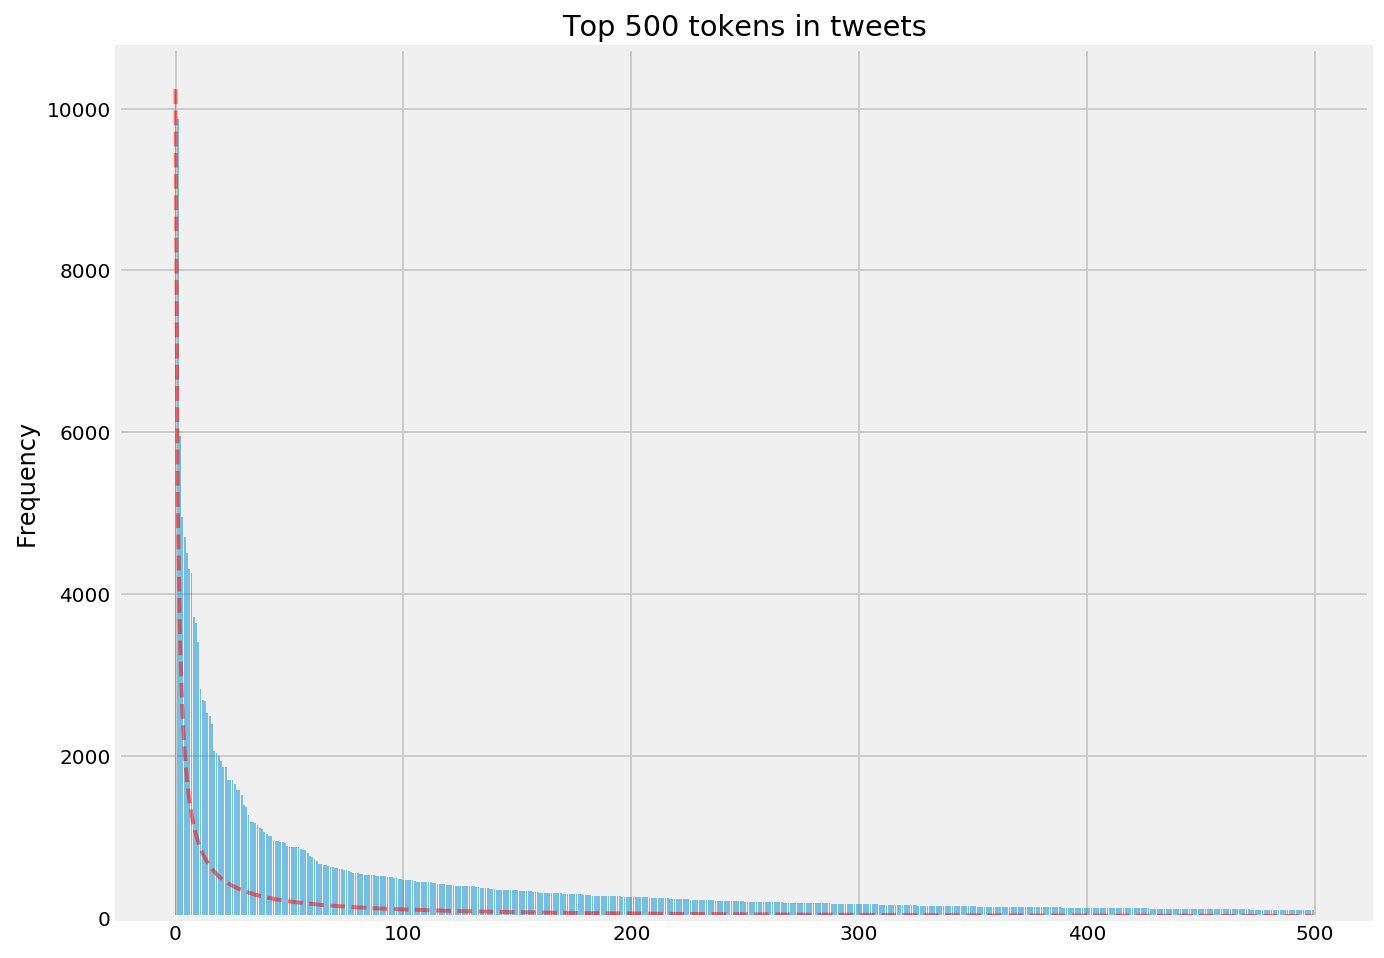

In [21]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

/home/kunal/anaconda3/lib/python2.7/site-packages/pandas/core/indexes/base.py:2560: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  tz=getattr(series.dtype, 'tz', None))


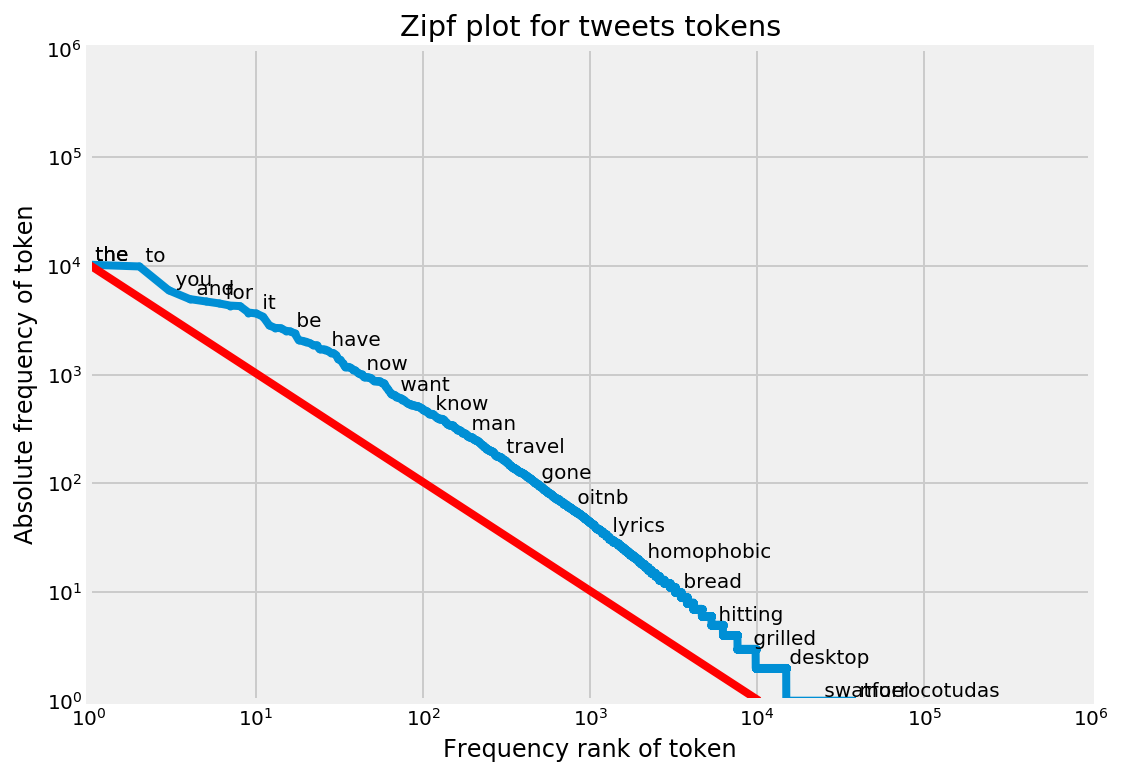

In [22]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.tweet)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [24]:
document_matrix = cvec.transform(my_df.tweet)

In [25]:
neg_tf = cvec.transform(my_df[my_df.label == 0].tweet)
pos_tf = cvec.transform(my_df[my_df.label == 1].tweet)
neg_x = np.sum(neg_tf,axis=0)
pos_x = np.sum(pos_tf,axis=0)
neg = np.squeeze(np.asarray(neg_x))
pos = np.squeeze(np.asarray(pos_x))
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
love,2801,27,2828
day,2384,9,2393
happy,1695,12,1707
just,1289,79,1368
like,1041,139,1180
life,1169,7,1176
time,1128,22,1150
today,1081,14,1095
new,931,72,1003
thankful,952,0,952


Text(0.5,1,u'Top 50 tokens in negative tweets')

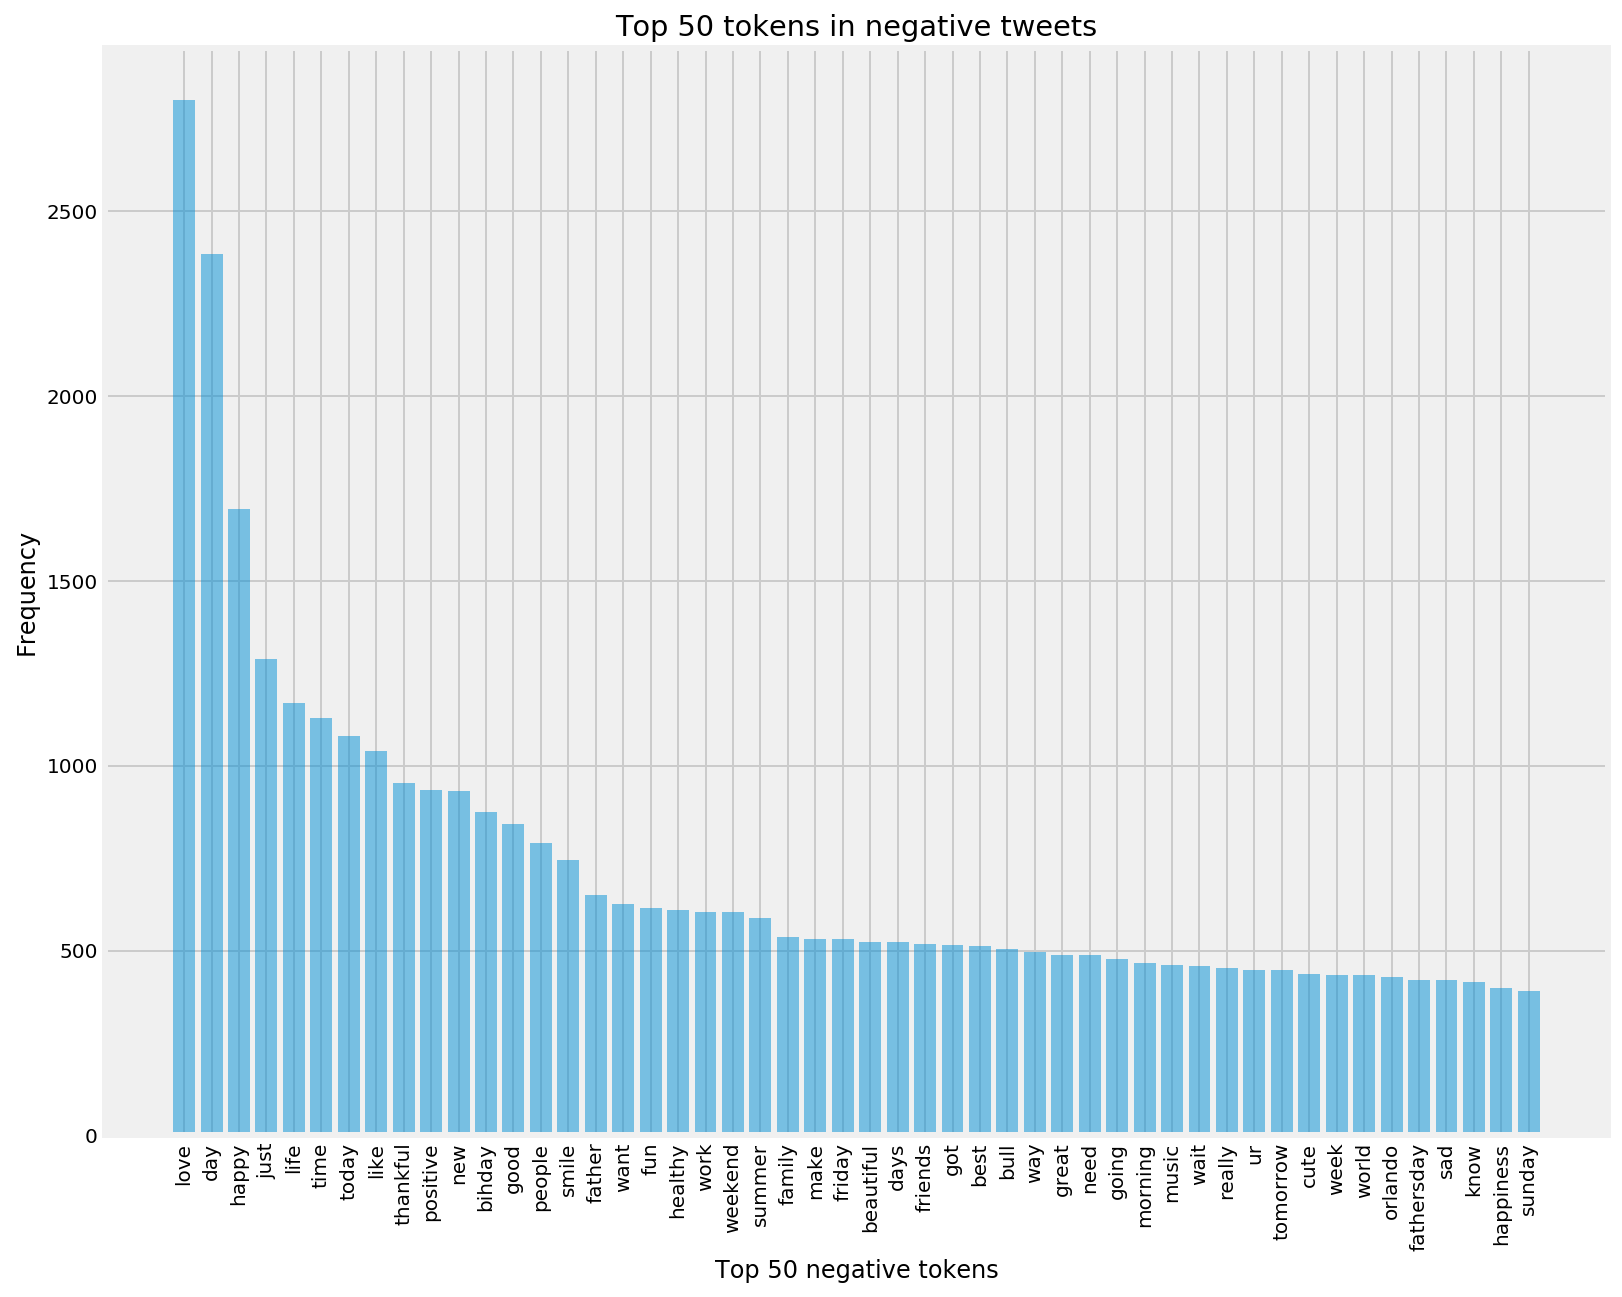

In [26]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5,1,u'Top 50 tokens in positive tweets')

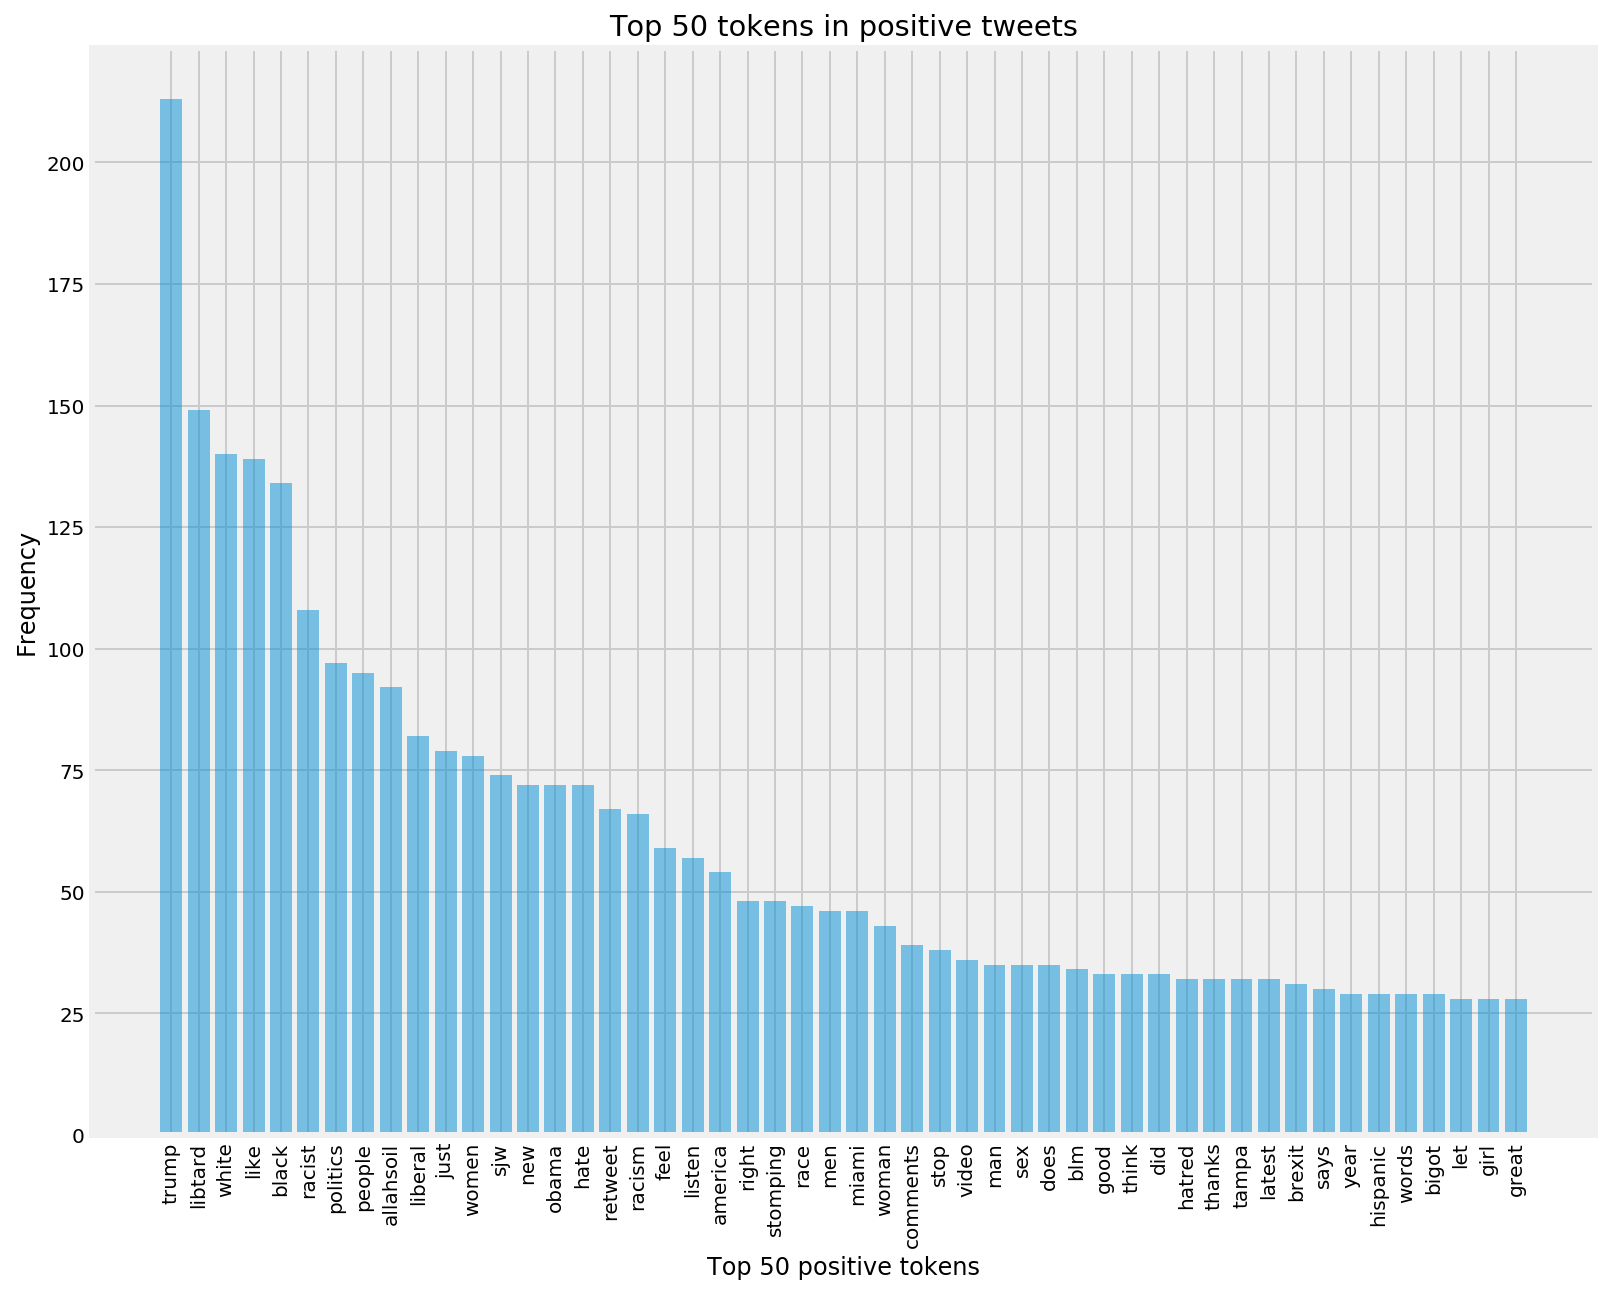

In [27]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5,1,u'Negative Frequency vs Positive Frequency')

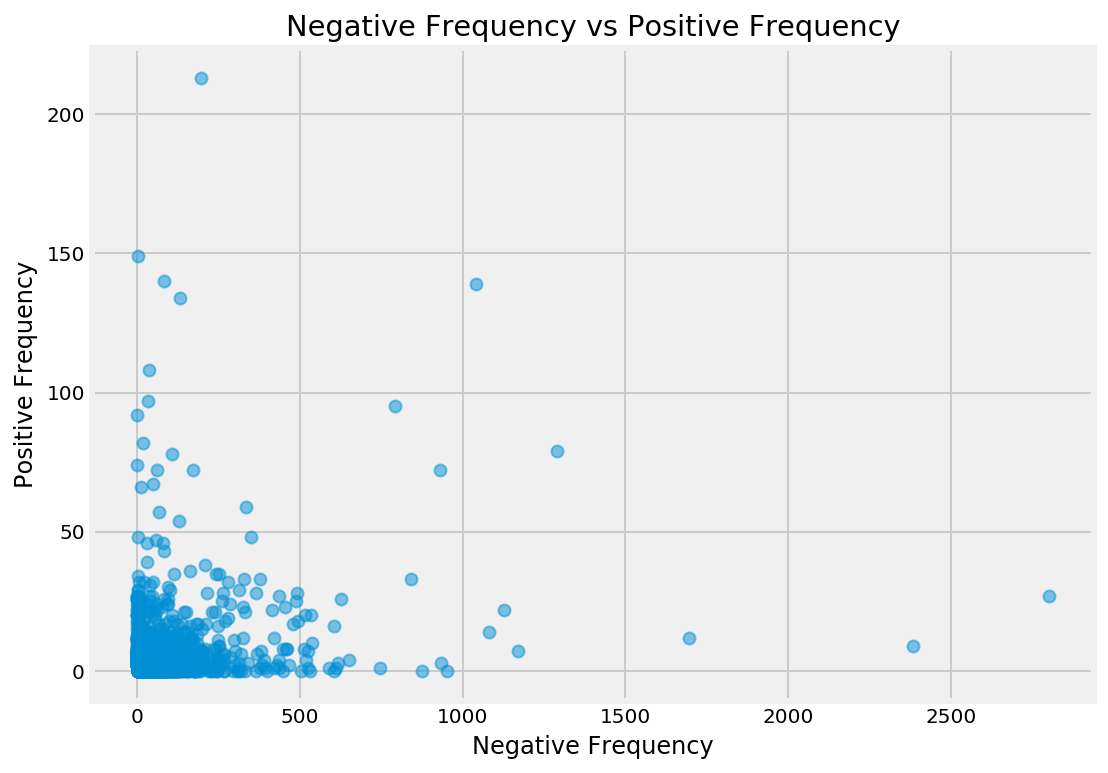

In [28]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [29]:
x = my_df.tweet
y = my_df.label
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train), (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 31318 entries with 92.98% negative, 7.02% positive
Validation set has total 320 entries with 92.50% negative, 7.50% positive
Test set has total 320 entries with 94.38% negative, 5.62% positive


In [30]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (classification_report(y_validation, tbpred))

Accuracy Score: 14.06%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                  19                   5
negative                 270                  26
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

          0       0.84      0.09      0.16       296
          1       0.07      0.79      0.12        24

avg / total       0.78      0.14      0.16       320



In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [32]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print "null accuracy: {0:.2f}%".format(null_accuracy*100)
    print "accuracy score: {0:.2f}%".format(accuracy*100)
    if accuracy > null_accuracy:
        print "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100)
    elif accuracy == null_accuracy:
        print "model has the same accuracy with the null accuracy"
    else:
        print "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100)
    print "train and test time: {0:.2f}s".format(train_test_time)
    print "-"*80
    return accuracy, train_test_time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print "\n"
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print "Validation result for {} features".format(n)
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [39]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print "null accuracy: {0:.2f}%".format(null_accuracy*100)
    print "accuracy score: {0:.2f}%".format(accuracy*100)
    if accuracy > null_accuracy:
        print "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100)
    elif accuracy == null_accuracy:
        print "model has the same accuracy with the null accuracy"
    else:
        print "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100)
    print "-"*80
    print "Confusion Matrix\n"
    print confusion
    print "-"*80
    print "Classification Report\n"
    print classification_report(y_test, y_pred, target_names=['negative','positive'])
    return y_pred

In [44]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
y_pred=train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)


null accuracy: 92.50%
accuracy score: 97.81%
model is 5.31% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 296                   0
positive                   7                  17
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.98      1.00      0.99       296
   positive       1.00      0.71      0.83        24

avg / total       0.98      0.98      0.98       320

CPU times: user 11.6 s, sys: 201 ms, total: 11.8 s
Wall time: 9.93 s


In [46]:
# Now, prepare our test data to test... it
test = pd.read_csv('test.csv')
test.tail(10)

,id,tweet
17187,49150,loving lifeðºð¸âï¸ð #createyourfutu...
17188,49151,"black professor demonizes, proposes nazi style..."
17189,49152,learn how to think positive. #positive #ins...
17190,49153,"we love the pretty, happy and fresh you! #teen..."
17191,49154,2_damn_tuff-ruff_muff__techno_city-(ng005)-web...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
17196,49159,"my song ""so glad"" free download! #shoegaze ..."


In [47]:
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [49]:
test_nums = [0,17197,800000,1200000,1600000]
print ("Cleaning and parsing the tweets...\n")
test_clean_tweet_texts = []
for i in range(test_nums[0],test_nums[1]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, test_nums[1] ))                                                                    
    test_clean_tweet_texts.append(tweet_cleaner(test['tweet'][i]))

Cleaning and parsing the tweets...

Tweets 10000 of 17197 has been processed


In [50]:
test_clean_df = pd.DataFrame(test_clean_tweet_texts,columns=['tweet'])
test_clean_df['id'] = test.id
test_clean_df.head()

,tweet,id
0,studiolife aislife requires passion dedication...,31963
1,white supremacists want everyone to see the ne...,31964
2,safe ways to heal your acne altwaystoheal heal...,31965
3,is the hp and the cursed child book up for res...,31966
4,rd bihday to my amazing hilarious nephew eli a...,31967


In [51]:
test_clean_df.to_csv('clean_tweet.csv',encoding='utf-8')
test_csv = 'clean_tweet.csv'
test_my_df = pd.read_csv(test_csv,index_col=0)
test_my_df.head()

,tweet,id
0,studiolife aislife requires passion dedication...,31963
1,white supremacists want everyone to see the ne...,31964
2,safe ways to heal your acne altwaystoheal heal...,31965
3,is the hp and the cursed child book up for res...,31966
4,rd bihday to my amazing hilarious nephew eli a...,31967


In [90]:
test_my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17197 entries, 0 to 17196
Data columns (total 2 columns):
tweet    17196 non-null object
id       17197 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [91]:
test_my_df[test_my_df.isnull().any(axis=1)].head()

,tweet,id
13404,NaN,45367


In [94]:
test_df = pd.read_csv("test.csv")
test_df.iloc[test_my_df[test_my_df.isnull().any(axis=1)].index,:].tweet

13404    @user @user awww....how   ð¢
Name: tweet, dtype: object

In [95]:
test_my_df.dropna(inplace=True)
test_my_df.reset_index(drop=True,inplace=True)
test_my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17196 entries, 0 to 17195
Data columns (total 2 columns):
tweet    17196 non-null object
id       17196 non-null int64
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [97]:
new_x_test = test_my_df.tweet
new_x_test.head(10)

0    studiolife aislife requires passion dedication...
1    white supremacists want everyone to see the ne...
2    safe ways to heal your acne altwaystoheal heal...
3    is the hp and the cursed child book up for res...
4    rd bihday to my amazing hilarious nephew eli a...
5                                 choose to be momtips
6    something inside me dies eyes ness smokeyeyes ...
7       finished tattoo inked ink loveit thanks aleeee
8    will never understand why my dad left me when ...
9    delicious food lovelife capetown mannaepicure ...
Name: tweet, dtype: object

In [71]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
test_sentiment_fit = tg_pipeline.fit(x_train, y_train)

CPU times: user 11.8 s, sys: 184 ms, total: 12 s
Wall time: 10.1 s


In [98]:
#new_x_test2=new_x_test[1:17196]
test_y_pred=test_sentiment_fit.predict(new_x_test)
test_y_pred[1:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
new_x_test

0        studiolife aislife requires passion dedication...
1        white supremacists want everyone to see the ne...
2        safe ways to heal your acne altwaystoheal heal...
3        is the hp and the cursed child book up for res...
4        rd bihday to my amazing hilarious nephew eli a...
5                                     choose to be momtips
6        something inside me dies eyes ness smokeyeyes ...
7           finished tattoo inked ink loveit thanks aleeee
8        will never understand why my dad left me when ...
9        delicious food lovelife capetown mannaepicure ...
10       dayswasted narcosis infinite ep make me aware ...
11       one of the world greatest spoing events lemans...
12       half way through the website now and allgoingw...
13       good food good life enjoy and this is called g...
14       ll stand behind this guncontrolplease senseles...
15       ate ate and ate jamaisasthi fish curry prawn h...
16          got my limited edition rain or shine set tod

In [122]:
np.savetxt("ans.csv", test_y_pred, delimiter=",")

In [167]:
#ans_prop = pd.DataFrame(test_y_pred,columns=['label'])
ans_prop1=pd.DataFrame(test.id,columns=['id'])
p=np.array(test_y_pred)
ans_prop1['label']=2
for x in range(13404):
    ans_prop1['label'][x]=p[x]

for x in range(13405,17197):
    ans_prop1['label'][x]=p[x-1]
ans_prop1.head(100)

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
5,31968,0
6,31969,0
7,31970,0
8,31971,0
9,31972,0


In [168]:
#np.savetxt("modified_ans.csv",ans_prop1 , delimiter=",")
ans_prop1.to_csv("test_predictions.csv", encoding='utf-8', index=False)